In [1]:
import sys

sys.path.append('../src/swfilter')

from models import SlicedWassersteinFilter, FastEuclidianFilter, SplitSlicedWassersteinFilter, SmartSplitSlicedWassersteinFilter

# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Albert Thomas <albert.thomas@telecom-paristech.fr>
#         Edited by Julien Pallage for academic purposes.
# License: BSD 3 clause

import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_blobs, make_moons
from sklearn.ensemble import IsolationForest
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
import ot



matplotlib.rcParams["contour.negative_linestyle"] = "solid"

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [2]:
n_outliers = 5
o = n_samples - n_outliers
n = int(o * (1-outliers_fraction))  # nb samples
m = int(o * outliers_fraction)  # nb samples


mu_s = np.array([-1, -1])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

mu_v = np.array((-2,6))
cov_v = np.array([[1, 0.2], [0.2, 1]])

xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(m, mu_t, cov_t)
xv = ot.datasets.make_2D_samples_gauss(n_outliers, mu_v, cov_v)


major_minor_out = np.vstack((xs, xt, xv))

Dataset 1:
Algorithm: Robust covariance
Algorithm: One-Class SVM
Algorithm: One-Class SVM (SGD)
Algorithm: Isolation Forest
Algorithm: Local Outlier Factor
Algorithm: SW
Algorithm: Split-SW
Algorithm: Fast Euclidian
Algorithm: Smart Split-SW
Dataset 2:
Algorithm: Robust covariance
Algorithm: One-Class SVM
Algorithm: One-Class SVM (SGD)
Algorithm: Isolation Forest
Algorithm: Local Outlier Factor
Algorithm: SW
Algorithm: Split-SW
Algorithm: Fast Euclidian
Algorithm: Smart Split-SW
Dataset 3:
Algorithm: Robust covariance
Algorithm: One-Class SVM
Algorithm: One-Class SVM (SGD)
Algorithm: Isolation Forest
Algorithm: Local Outlier Factor
Algorithm: SW
Algorithm: Split-SW
Algorithm: Fast Euclidian
Algorithm: Smart Split-SW
Dataset 4:
Algorithm: Robust covariance
Algorithm: One-Class SVM
Algorithm: One-Class SVM (SGD)
Algorithm: Isolation Forest
Algorithm: Local Outlier Factor
Algorithm: SW
Algorithm: Split-SW
Algorithm: Fast Euclidian
Algorithm: Smart Split-SW
Dataset 5:
Algorithm: Robust cov

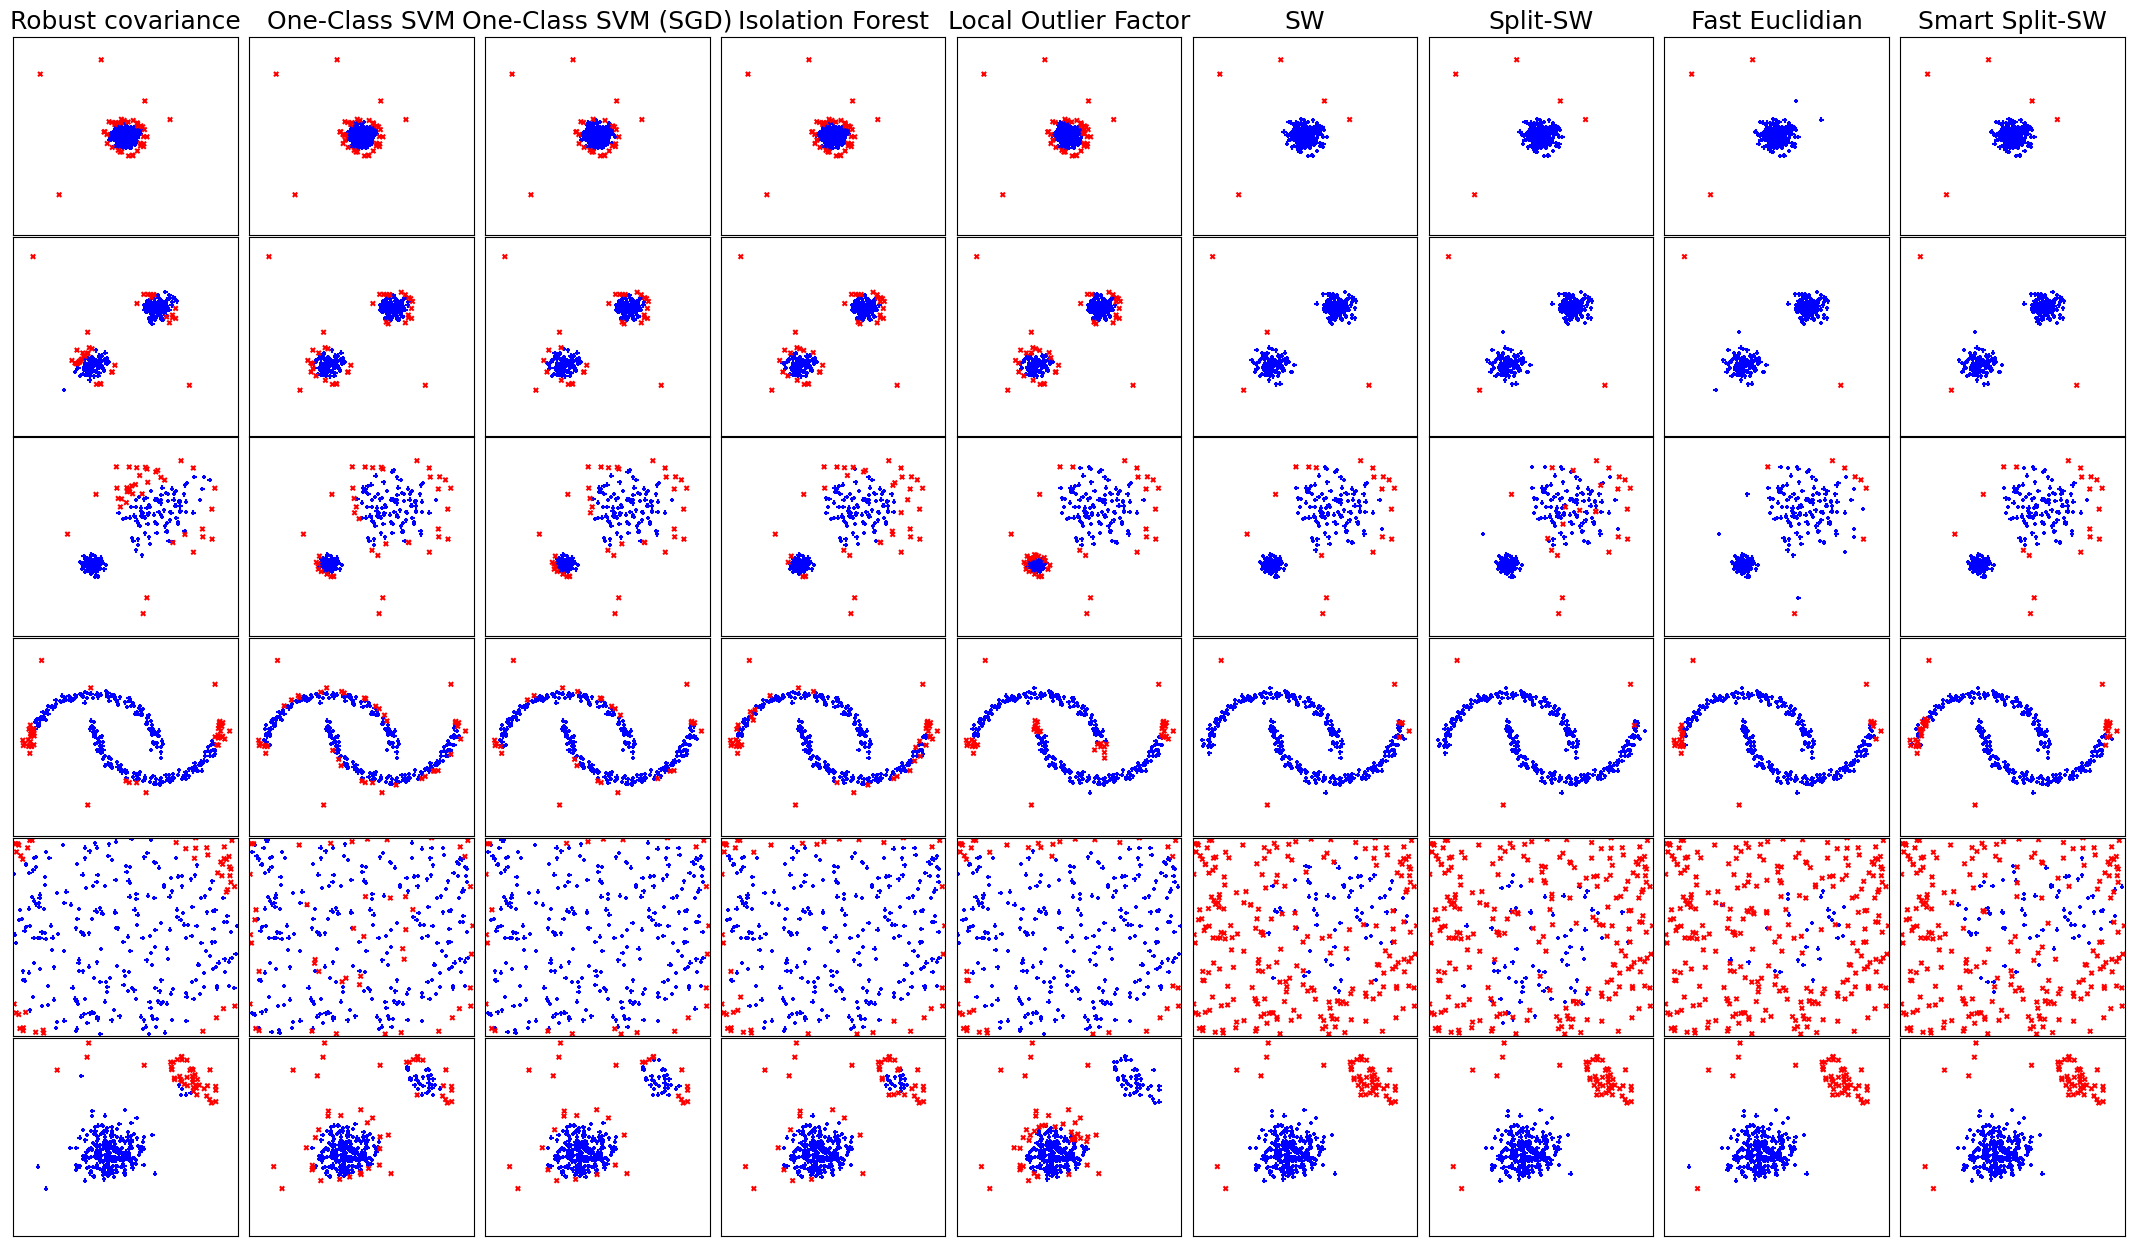

In [ ]:


# define outlier/anomaly detection methods to be compared.
# the SGDOneClassSVM must be used in a pipeline with a kernel approximation
# to give similar results to the OneClassSVM

anomaly_algorithms = [(
    "Robust covariance",
    EllipticEnvelope(contamination=outliers_fraction, random_state=42),
),
("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
(
    "One-Class SVM (SGD)",
    make_pipeline(
        Nystroem(gamma=0.1, random_state=42, n_components=150),
        SGDOneClassSVM(
            nu=outliers_fraction,
            shuffle=True,
            fit_intercept=True,
            random_state=42,
            tol=1e-6,
        ),
    ),
),
(
"Isolation Forest",
IsolationForest(contamination=outliers_fraction, random_state=42),
),
(
"Local Outlier Factor",
LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
),(

    "SW",
    SlicedWassersteinFilter(eps=0.03, n=50, n_projections=200, p=0.7, n_jobs=-1, swtype='original'), #50, 200
),
(
    "Split-SW",
    SplitSlicedWassersteinFilter(eps=0.03, n=80, n_projections=200, p=0.7, n_jobs=-1, swtype='original', n_clusters=2),
),

(
    "Fast Euclidian",
    FastEuclidianFilter(eps=4.5, n=200, p=0.7, n_jobs=-1),
),
(
    "Smart Split-SW",
    SmartSplitSlicedWassersteinFilter(eps=0.03, n=100, n_projections=200, p=0.7, seed=42, n_jobs=-1, swtype='original', n_clusters=2, n_splits=2),
),

]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
    14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
    major_minor_out,
]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
counter = 0
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    counter += 1
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)
    X = shuffle(X, random_state=42)
    print(f"Dataset {counter}:")
    for name, algorithm in anomaly_algorithms:
        print(f"Algorithm: {name}")

        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor" :
            y_pred = algorithm.fit_predict(X)
        elif name == "SW" or name == "Fast Euclidian" or name == "Split-SW" or name == "Smart Split-SW":
            y_pred, vote = algorithm.fit_predict(X)

        else:
            y_pred = algorithm.fit(X).predict(X)


        colors = np.array(["red", "blue"])
        markers = np.array(["x", "+"])
        # Plot the points with different markers
        for marker in np.unique(markers):
            mask = markers[(y_pred + 1) // 2] == marker
            plt.scatter(X[mask, 0], X[mask, 1], s=10, color=colors[(y_pred[mask] + 1) // 2], marker=marker)


        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1
plt.savefig("comparison_toy_dataset.pdf", dpi=400)
plt.show()
